# Mathematical Optimization, Theory and Practice

Niels van der Laan, Joaquim Gromicho, 2023

---
 > During this course we make use of Jupyter notebooks hosted by [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb).
 The usage of this platform is allowed by ORTEC for **educational and personal experimentation only**. May you consider using it for a project please consult the IT department.
 Notebooks deployed on `colab` require neither python nor other dependencies to be installed on your own machine, you only need a browser (preferably `chrome`) and you may also need a google account if you want to execute them.

---

Let us suppose now that Caroline is so successful that she considers opening a number of distribution centers to support scaling up her production.

Taking into account her costumers $J$ and a set $I$ of possible locations for her new distribution centers she estimates the costs $c_j$ of opening at $j \in J$ and $d_{ij}$ of serving $i \in I$ from $j \in J$.

Her decision variables are:
     
$$
   x_j = \left\{
     \begin{array}{lr}
       1 & \mbox{center } j \mbox{ is built}\\
       0 & \mbox{otherwise}\\
     \end{array}
   \right.
       \mbox{ and }
   y_{ij} = \left\{
     \begin{array}{lr}
       1 & \mbox{customer } i \mbox{ is served at } j\\
       0 & \mbox{otherwise}\\
     \end{array}
   \right.
$$

Minimizing the number of bins used provided that each item goes in a bin and the sum of the sizes $s_i$ of items in the same bin do not exceed the capacity $c$ is:
$$
\begin{array}{rrcll}
\min    & \sum_{j\in J} c_jx_j + \sum_{i \in I, j \in J} d_{ij}y_{ij}\\
s.t.    & \sum_{j\in J} y_{ij}     & =    & 1     & \forall i \in I \\
        & \sum_{i\in I} y_{ij}     & \leq & n x_j & \forall j \in J \\
        & y_{ij} \in \{0,1\}       &      &       & \forall i \in I, j \in J \\
        & x_j \in \{0,1\}          &      &       & \forall j \in J \\
\end{array}
$$
       
The disaggregated model which is claimed to be stronger is:
$$
\begin{array}{rrcll}
\min    & \sum_{j\in J} c_jx_j + \sum_{i \in I, j \in J} d_{ij}y_{ij}\\
s.t.    & \sum_{j\in J} y_{ij}     & =    & 1     & \forall i \in I \\
        &               y_{ij}     & \leq & x_j   & \forall i \in I, j \in J \\
        & y_{ij} \in \{0,1\}       &      &       & \forall i \in I, j \in J \\
        & x_j \in \{0,1\}          &      &       & \forall j \in J \\
\end{array}
$$

In [ ]:
# install Pyomo and solvers
import sys, os, shutil

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre >/dev/null 2>/dev/null
    !idaes get-extensions --to ./bin
    os.environ['PATH'] += ':bin'
    !pip install highspy >/dev/null 2>/dev/null

    if not shutil.which('/usr/bin/glpsol'):
        !sudo apt install libglpk-dev python3.8-dev libgmp3-dev
        !apt-get install -y -qq glpk-utils
        assert(shutil.which('/usr/bin/glpsol'))

Getting files...
Done
---------------------------------------------------
IDAES Extensions Build Versions
Solvers:  vno version file found
Library:  vno version file found
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3.8-dev is already the newest version (3.8.10-0ubuntu1~20.04.8).
python3.8-dev set to manually installed.
The following additional packages will be installed:
  libamd2 libbtf1 libcamd2 libccolamd2 libcholmod3 libcolamd2 libcxsparse3
  libglpk40 libgmp-dev libgmpxx4ldbl libgraphblas3 libklu1 libldl2 libmetis5
  libmongoose2 librbio2 libspqr2 libsuitesparse-dev libsuitesparseconfig5
  libumfpack5
Suggested packages:
  libiodbc2-dev gmp-doc libgmp10-doc libmpfr-dev
The following NEW packages will be installed:
  libamd2 libbtf1 libcamd2 libccolamd2 libcholmod3 libcolamd2 libcxsparse3
  libglpk-dev libglpk40 libgmp-dev libgmp3-dev libgmpxx4ldbl libgraphblas3
  libklu1 libldl2 libmetis5 libmongoose2 librbio2 libspqr2 lib

In [2]:
from time import perf_counter as pc
from tqdm.notebook import tqdm
import pandas as pd, itertools as it, pyomo.environ as pyo, numpy as np, subprocess
import gurobipy

In [3]:
def FacilityLocationCommon(installation, service):
    model = pyo.ConcreteModel("Facility location")
    model.facilities = range(len(installation))
    model.customers = range(len(service))

    model.x = pyo.Var(model.facilities, within=pyo.Binary)
    model.y = pyo.Var(model.customers, model.facilities, within=pyo.Binary)

    @model.Objective(sense=pyo.minimize)
    def obj(model):
        return sum([installation[j] * model.x[j] for j in model.facilities]) + sum(
            [
                service[i][j] * model.y[i, j]
                for i in model.customers
                for j in model.facilities
            ]
        )

    @model.Constraint(model.customers)
    def ChooseOneFacility(model, i):
        return sum([model.y[i, j] for j in model.facilities]) == 1

    return model


def FacilityLocationWeak(installation, service):
    model = FacilityLocationCommon(installation, service)

    @model.Constraint(model.facilities)
    def ServeIfOpen(model, j):
        return (
            sum([model.y[i, j] for i in model.customers])
            <= len(model.customers) * model.x[j]
        )

    return model


def FacilityLocationStrong(installation, service):
    model = FacilityLocationCommon(installation, service)

    @model.Constraint(model.customers, model.facilities)
    def ServeIfOpen(model, i, j):
        return model.y[i, j] <= model.x[j]

    return model

In [4]:
def GetSolution(model):
    X = [model.x[j]() >= 0.5 for j in model.facilities]
    Y = [[model.y[i, j]() >= 0.5 for j in model.facilities] for i in model.customers]
    return X, Y, model.obj()

In [5]:
def GenerateFacilityLocationInstance(nofFacilities, nofCustumers):
    facilities = range(nofFacilities)
    customers = range(nofCustumers)
    xC = np.random.randint(0, 100, nofCustumers)
    yC = np.random.randint(0, 100, nofCustumers)
    xF = np.random.randint(0, 100, nofFacilities)
    yF = np.random.randint(0, 100, nofFacilities)

    installation = np.random.randint(100, 200, nofFacilities)

    dist = lambda i, j: ((xC[i] - xF[j]) ** 2 + (yC[i] - yF[j]) ** 2)

    service = [[dist(i, j) for j in facilities] for i in customers]

    return installation, service, xC, yC, xF, yF

In [6]:
def ShowFacilityLocation(xC, yC, xF, yF, X=[], Y=[], title=None):
    import matplotlib.pyplot as plt

    [
        plt.plot([xC[i], xF[j]], [yC[i], yF[j]], "g-")
        for j in range(len(X))
        if X[j]
        for i in range(len(Y))
        if Y[i][j]
    ]
    plt.plot(xC, yC, "o")
    plt.plot(xF, yF, "s")
    if title:
        plt.title(title)
    plt.show()

In [7]:
installation, service, xC, yC, xF, yF = GenerateFacilityLocationInstance(10, 100)

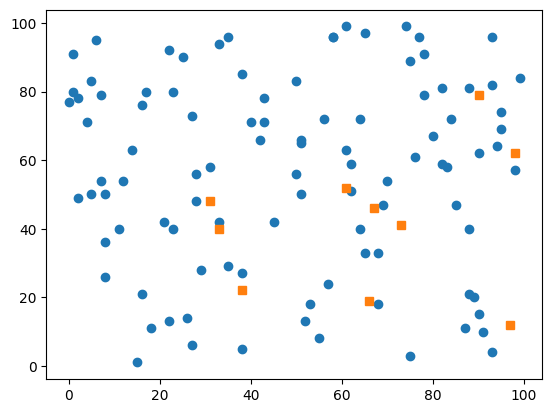

In [8]:
ShowFacilityLocation(xC, yC, xF, yF)

In [9]:
weak = FacilityLocationWeak(installation, service)
strong = FacilityLocationStrong(installation, service)

CPU times: user 30.2 ms, sys: 7.62 ms, total: 37.8 ms
Wall time: 31.3 ms


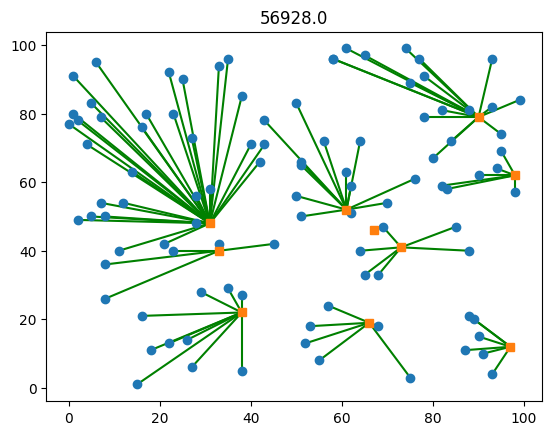

In [11]:
solver = 'gurobi_direct'
%time pyo.SolverFactory(solver).solve(weak)
ShowFacilityLocation( xC, yC, xF, yF, *GetSolution(weak) )

CPU times: user 39 ms, sys: 4.3 ms, total: 43.3 ms
Wall time: 40.4 ms


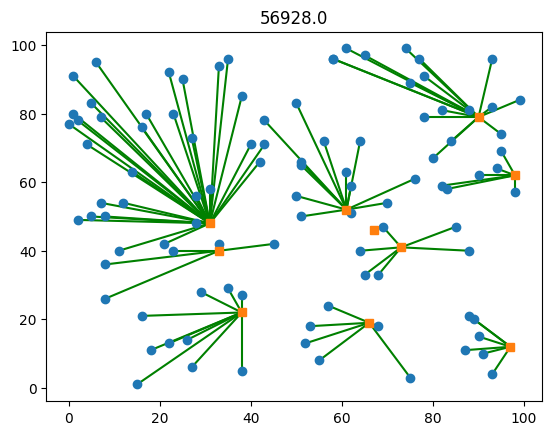

In [12]:
%time pyo.SolverFactory(solver).solve(strong)
ShowFacilityLocation( xC, yC, xF, yF, *GetSolution(strong) )

# The solver may aliviate the problem

`glpk` is ideal to test the strength of models, since it does not modify the instances very much. `cbc` is already a bit more clever...

CPU times: user 11.7 ms, sys: 10.5 ms, total: 22.2 ms
Wall time: 66.6 ms


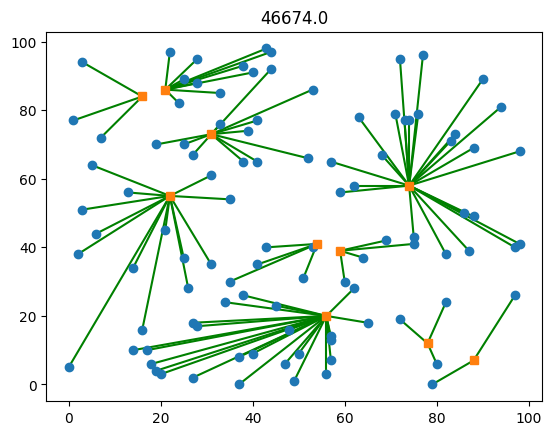

In [12]:
solver = 'cbc'
%time pyo.SolverFactory(solver).solve(weak)
ShowFacilityLocation( xC, yC, xF, yF, *GetSolution(weak) )

CPU times: user 13.9 ms, sys: 9.71 ms, total: 23.6 ms
Wall time: 48.5 ms


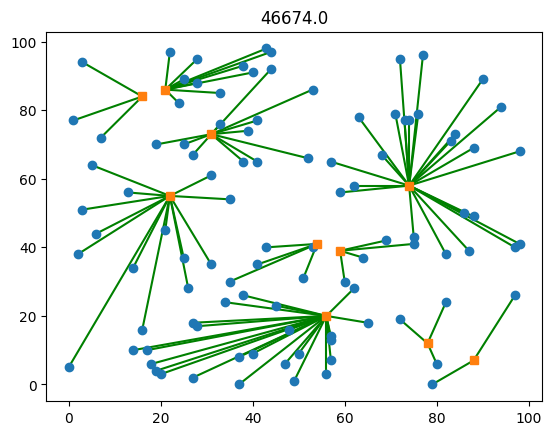

In [13]:
%time pyo.SolverFactory(solver).solve(strong)
ShowFacilityLocation( xC, yC, xF, yF, *GetSolution(strong) )

The commercial solvers are very good at disagregating. If we keep our instances small we can solve them with the free community editions of `gurobi`, `cplex` and `xpress`.

In [ ]:
if 'google.colab' in sys.modules:
    !pip install gurobipy
    !pip install cplex
    !pip install xpress

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 58.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.2/70.2 MB 8.3 MB/s eta 0:00:00


In [1]:
installation, service, xC, yC, xF, yF = GenerateFacilityLocationInstance(8, 88)
weak = FacilityLocationWeak(installation, service)
strong = FacilityLocationStrong(installation, service)
for solver in ["gurobi_direct", "cplex_direct", "xpress_direct"]:
    t = pc()
    pyo.SolverFactory(solver).solve(weak)
    t = pc() - t
    X, Y, value = GetSolution(weak)
    ShowFacilityLocation(xC, yC, xF, yF, X, Y, f"{value:.0f} {t:5.1f} weak {solver}")
    t = pc()
    pyo.SolverFactory(solver).solve(strong)
    t = pc() - t
    X, Y, value = GetSolution(weak)
    ShowFacilityLocation(xC, yC, xF, yF, X, Y, f"{value:.0f} {t:5.1f} weak {solver}")

NameError: name 'GenerateFacilityLocationInstance' is not defined

In [ ]:
shell_command = "pyomo help --solvers"
output = subprocess.check_output(shell_command, shell=True).decode()
solvers = [
    line.strip()[1:]
    for line in output.split()
    if line.strip().startswith("+") and not line.strip().endswith(")")
]

In [ ]:
solvers

['appsi_cbc',
 'appsi_cplex',
 'appsi_gurobi',
 'appsi_highs',
 'appsi_ipopt',
 'cbc',
 'cplex_direct',
 'cplex_persistent',
 'gdpopt',
 'gdpopt.gloa',
 'gdpopt.lbb',
 'gdpopt.loa',
 'gdpopt.ric',
 'glpk',
 'gurobi',
 'gurobi_direct',
 'gurobi_persistent',
 'ipopt',
 'mindtpy',
 'mindtpy.ecp',
 'mindtpy.fp',
 'mindtpy.goa',
 'mindtpy.oa',
 'mpec_minlp',
 'mpec_nlp',
 'multistart',
 'scipy.fsolve',
 'scipy.newton',
 'scipy.root',
 'scipy.secant-newton',
 'trustregion',
 'xpress',
 'xpress_direct',
 'xpress_persistent']

In [13]:
use_these_solvers = ["gurobi_direct", "cbc", "appsi_highs"]

In [14]:
def These(dimensions, solvers, seed):
    np.random.seed(seed)
    model = {"weak": FacilityLocationWeak, "strong": FacilityLocationStrong}
    df = pd.DataFrame(
        index=dimensions,
        columns=[f"{s}_{m}" for s, m in it.product(solvers, model.keys())],
    )
    for n, m in tqdm(df.index):
        installation, service, xC, yC, xF, yF = GenerateFacilityLocationInstance(n, m)
        instance = {
            option: model[option](installation, service) for option in model.keys()
        }
        values = []
        for column in tqdm(df.columns, leave=False):
            solver = column[: column.rfind("_")]
            option = column[column.rfind("_") + 1 :]
            t = pc()
            pyo.SolverFactory(solver).solve(instance[option])
            df.at[(n, m), column] = pc() - t
            _, _, v = GetSolution(instance[option])
            values.append(v)
        assert len(set(values)) == 1, values
    return df

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms
Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms


  0%|          | 0/6 [00:00<?, ?it/s]

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms
Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms


  0%|          | 0/6 [00:00<?, ?it/s]

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms
Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms


<Axes: >

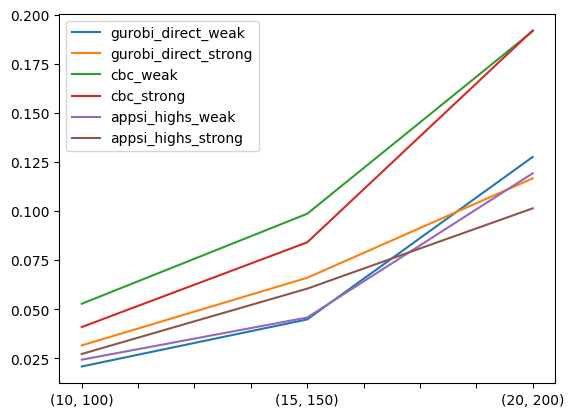

In [15]:
These([(n, 10 * n) for n in range(10, 21, 5)], use_these_solvers, 2023).plot()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms
Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms


  0%|          | 0/6 [00:00<?, ?it/s]

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms
Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms


  0%|          | 0/6 [00:00<?, ?it/s]

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms
Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms


  0%|          | 0/6 [00:00<?, ?it/s]

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms
Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms


  0%|          | 0/6 [00:00<?, ?it/s]

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms
Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms


  0%|          | 0/6 [00:00<?, ?it/s]

Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms
Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms


<Axes: >

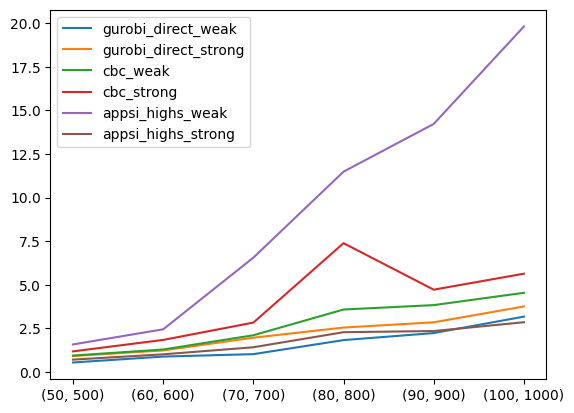

In [16]:
These([(n, 10 * n) for n in range(50, 101, 10)], use_these_solvers, 2023).plot()